In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-d78fd842-1feb-ab5c-9718-51ee59194da8)


# Packages

In [ ]:
import h5py
import math
import numpy as np
import os
import random
from tqdm import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Model Layers

## Transformer Class

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_head, num_layers, feedforward_dim):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(embed_dim, num_head, feedforward_dim)
        encoder_layer.self_attn.batch_first = True
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x, mask = None):
        x_norm = self.norm(x)
        if mask != None:
          output = self.transformer_encoder(x_norm, mask=mask)
        else:
          output = self.transformer_encoder(x_norm)
        return output + x_norm

## Embedding Methods

### Linear

In [ ]:
class PatchEmbedding_Linear(nn.Module):
    '''
      Expected Input is of shape (batch_size, window_length, grid_height, grid_width, num_grids)
      Reshaping is performed within forward pass and shape becomes: (batch_size, window_length, grid_height, grid_width*num_grids)
      Args:
        D (int): Depth, Time dimension split for tubelet,
                    if D = window_length, no patching across window
        H (int): Height, vertical channel split for patching,
                    if H = grid_height, no patching along grid channel rows
        W (int): Width, horizontal channel split for patching,
                    if W = grid_width*num_grids, no patching along grid channel columns
        Note: (D, H, W) is the tubelet size being embedded.
        Sgr (tuple): Selected grid rows, tuple of index range for rows of the combined horizontally stacked grids
                        (e.g. For the full sized grids of 8x8x2 stacked become (8,16))
        Sgc (tuple): Selected grid columns, tuple of index range for columns of combined horizontally stacked grids
                        (e.g. (:,0:8) indicates flexor, (:, 8:16) indicates extensor))
        Note: (Grid_rows, Grid_cols) selected from horizontally stacked, combined, grids
        embed_dim (int): embedding dimension, size of hidden layers through the network
      Returns:
        output is the linear embedding prepended with the cls token, shape (batch_size, N+1, embed_dim), N is the number of tubelets in the the data volume
    '''
    def __init__(self, window_length, Sgr, Sgc, D, H, W, embed_dim):
        super().__init__()
        self.D = D
        self.H = H
        self.W = W
        self.Sgr_i, self.Sgr_j = Sgr
        self.Sgr_len = len(range(Sgr[0],Sgr[1]))
        self.Sgc_i, self.Sgc_j = Sgc
        self.Sgc_len = len(range(Sgc[0],Sgc[1]))
        # N must be an integer unless we decide to pad inputs
        self.N = (window_length * self.Sgr_len * self.Sgc_len) // (D * H * W)
        assert isinstance(self.N, int), "N, the number of tubelets/patches, must be an integer"
        self.embed_dim = embed_dim
        self.proj = nn.Linear(D * H * W, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, x):
        batch_size, window_length, grid_height, grid_width, num_grids = x.shape
        #print("batch_size, window_length, grid_height, grid_width, num_grids:", batch_size, window_length, grid_height, grid_width, num_grids)
        x = x.reshape(batch_size, window_length, self.Sgr_len, -1) # Handles any number of grids
        # Select desired Subgrids with which to process, this could be just flexor or extensor depending on selection
        x = x[:,:,self.Sgr_i:self.Sgr_j,self.Sgc_i:self.Sgc_j]
        #print(batch_size*self.N, self.D * self.H * self.W)
        x = x.unfold(1, self.D, self.D).unfold(2, self.H, self.H).unfold(3, self.W, self.W)
        x = x.contiguous().view(batch_size * self.N, self.D * self.H * self.W).float()
        x = self.proj(x)
        # Transformer type models expect inputs of shape(batch_size, sequence_length, embed_dim)
        x = x.view(batch_size, self.N, -1)
        # CLS tokens of shape (batch_size, 1, embed_dim) is prepended to the linear embedding
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        # Append CLS token instead of Prepend
        x = torch.cat((x, cls_tokens), dim=1)
        return x


### Convolutional

In [ ]:
class PatchEmbedding_Conv(nn.Module):
    def __init__(self, tubelet_size, in_channels, embed_dim):
        super().__init__()

        self.proj = nn.Conv3d(in_channels, embed_dim, kernel_size=tubelet_size, stride=tubelet_size)
        self.in_channels = in_channels
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, x):
        # x is of shape (batch_size, num_grids, window_length, height, width)
        # (batch_size, 1, window_length, 8, 16)
        x = x.reshape(x.shape[0], self.in_channels, x.shape[2], x.shape[3], -1)
        # reshape to (batch_size, 1, window_length, 8, 16)
        #print("input_shape:", x.shape)
        x = self.proj(x).flatten(2).transpose(1, 2)  # apply 3D convolution
        #print("reshaped_conv_output", x.shape)
        # CLS tokens of shape (batch_size, 1, embed_dim) is prepended to the linear embedding
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((x, cls_tokens), dim=1)
        #print("embed+cls shape:", x.shape)
        return x


## Positional Encoding

In [ ]:
# Trainable Positional Encoding
class PositionalEncoding(nn.Module):
  def __init__(self, N, embed_dim):
    super().__init__()
    self.pos_encoding = nn.Parameter(torch.randn(1, N, embed_dim))
  def forward(self, x):
    #print("self.pos_encoding:", self.pos_encoding)
    return x + self.pos_encoding


In [ ]:
class PositionalEncoding_Sinusoidal(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class PositionalEncoding_Sinusoidal_3D(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding_Sinusoidal_3D, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 3) * -(np.log(10000.0) / d_model))  # change 2 to 3
        pe[:, 0::3] = torch.sin(position * div_term)
        pe[:, 1::3] = torch.cos(position * div_term)
        pe[:, 2::3] = torch.sin(position * div_term)  # add an additional dimension
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


## Classifier Block

In [ ]:
class Classifier(nn.Module):
    def __init__(self, hidden_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        return F.softmax(self.linear(x), dim=-1)


# Data Loading Functions

In [ ]:
# Load multiple h5 file
class HDF5Dataset(Dataset):
    def __init__(self, h5_files):
        self.h5_files = [h5py.File(file, 'r') for file in h5_files]
        self.lengths = [len(file['/data']) for file in self.h5_files]
        self.total_length = sum(self.lengths)

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        for i in range(len(self.h5_files)):
            if idx < self.lengths[i]:
                data = torch.from_numpy(self.h5_files[i]['/data'][idx])
                label = torch.from_numpy(self.h5_files[i]['/labels'][idx])
                return data, label
            idx -= self.lengths[i]

# Model Training Function

In [ ]:
def train_model(model, train_loader, test_loader, lr, criterion, num_epochs, device):
  # Optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=3.761442064018126e-08)
  #optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

  # LR scheduler
  #lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.9, patience=10, verbose=True)
  #lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

  # For early stopping
  n_epochs_stop = 100
  #min_val_loss = np.Inf
  max_val_acc = 0.0
  epochs_no_improve = 0

  # Layer for visualization
  selected_layer = 0


  # History
  train_loss_hist = []
  train_acc_hist = []
  val_loss_hist = []
  val_acc_hist = []

  model_save_name = "current_best_model_{}.pt".format(model.__class__.__name__)

  # Send Model to Device
  if torch.cuda.device_count() > 1:
      print("Found", torch.cuda.device_count(), "GPUs, Using DataParallel")
      model = nn.DataParallel(model)

  model.to(device)

  # Training loop
  for epoch in range(num_epochs):
      # Training phase
      train_loss = 0.0
      train_correct = 0
      train_total = 0
      model.train()
      train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/ {num_epochs}", position=0)
      for inputs, labels in train_bar:
          inputs, labels = inputs.to(device), torch.argmax(labels, dim=1).to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          _, predicted = torch.max(outputs.data, 1)
          train_total += labels.size(0)
          train_correct += (predicted == labels).sum().item()
          train_loss += loss.item()

          train_bar.set_postfix({'train_loss': train_loss / (train_total + 1e-10), 'train_acc': train_correct / train_total})

      train_acc = train_correct / train_total
      train_loss /= len(train_loader)
      train_loss_hist.append(train_loss)
      train_acc_hist.append(train_acc)

      # Validation phase
      model.eval()
      val_loss = 0.0
      val_correct = 0
      val_total = 0
      with torch.no_grad():
          for inputs, labels in test_loader:
              inputs, labels = inputs.to(device), torch.argmax(labels, dim=1).to(device)
              outputs = model(inputs)
              val_loss += criterion(outputs, labels).item()
              _, predicted = torch.max(outputs.data, 1)
              val_total += labels.size(0)
              val_correct += (predicted == labels).sum().item()

      val_acc = val_correct / val_total
      val_loss /= len(test_loader)
      val_loss_hist.append(val_loss)
      val_acc_hist.append(val_acc)


      print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Val Loss: {val_loss}, Val Accuracy: {val_acc}')

      if epoch % 10 == 0:
        # Invoke garbage collection
        gc.collect()

        # If using CUDA, you can also clear the CUDA memory cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


      # # Check early stopping condition
      # if val_loss < min_val_loss:
      #     epochs_no_improve = 0
      #     min_val_loss = val_loss

      #     # Save the model
      #     torch.save(model.state_dict(), 'best_model.pt')
      # else:
      #     epochs_no_improve += 1

      # Check if validation accuracy has improved
      if val_acc > max_val_acc:
          epochs_no_improve = 0
          max_val_acc = val_acc

          # Save the model
          torch.save(model.state_dict(), model_save_name)
          print(f'Validation accuracy has improved. Saving the model.')
      else:
          epochs_no_improve += 1

      # Check for early stopping
      #if epochs_no_improve == n_epochs_stop:
      #    print('Early stopping!')
      #    break

      # step the lr scheduler
      #lr_scheduler.step(val_acc)
      lr_scheduler.step()

  print('Finished Training')

  histories_dict = {"train_loss": train_loss_hist, "train_acc": train_acc_hist,
                    "val_loss": val_loss_hist, "val_acc": val_acc_hist,}

  # Return Current Best Model
  model.load_state_dict(torch.load(model_save_name))

  return model, histories_dict


In [ ]:
def eval_model(model, train_loader, test_loader, device, save_path, save_name):
    model.eval()
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        for inputs, labels in tqdm(train_loader, desc="Train_Eval", position=0):
            inputs, labels = inputs.to(device), torch.argmax(labels, dim=1).to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
    train_acc = correct_train / total_train

    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Val_Eval", position=0):
            inputs, labels = inputs.to(device), torch.argmax(labels, dim=1).to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_acc = correct_test / total_test

    print('\nTrain: %.3f, Test: %.3f' % (train_acc, test_acc))

    np.save(os.path.join(save_path,"test_acc_{}".format(save_name)), test_acc)

    return

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


# Data Loading

In [ ]:
#####################################
# Choose subjects and desired percentage of reps
subjects = [1,2,3,4,5,6,
            7,8,9,10,11,12,
            13,14,15,16,17,18,
            19,20]

#subject = subjects[int(os.getenv("SLURM_ARRAY_TASK_ID"))]
subject = 1
print('selected_subject: {}'.format(subject))
#####################################


selected_subject: 1


In [ ]:
batch_size = 32
global_batch_size = int(batch_size*torch.cuda.device_count())

h5_data_directory = '/my/path/to/z-score/data/'

train_data_file = f'train_dataset_s{subject}.h5'
test_data_file = f'test_dataset_s{subject}.h5'

h5_train_data_path = os.path.join(h5_data_directory + train_data_file)
h5_test_data_path = os.path.join(h5_data_directory + test_data_file)

# Create your datasets
train_dataset = HDF5Dataset([h5_train_data_path])
test_dataset = HDF5Dataset([h5_test_data_path])

# Create your data loaders
train_loader = DataLoader(train_dataset, batch_size=global_batch_size, shuffle=True, num_workers=4) #, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=global_batch_size, num_workers=4) # , drop_last=True)

In [ ]:
# Check DataLoader's data type and shape
dataiter = iter(train_loader)
images, labels = next(dataiter)

print("Type of images:", type(images))
print("Shape of images:", images.shape)

print("Type of labels:", type(labels))
print("Shape of labels:", labels.shape)

Type of images: <class 'torch.Tensor'>
Shape of images: torch.Size([32, 400, 6, 6, 2])
Type of labels: <class 'torch.Tensor'>
Shape of labels: torch.Size([32, 65])


# Model Training

In [ ]:
print(torch.__version__)

2.2.1+cu121


## Vision Transformer

### Linear Embedding

#### Causal Attention Mask

In [ ]:
# Last Token Classification
class Vi_Transformer_Linear(nn.Module):
    def __init__(self, window_length, Sgr, Sgc, D, H, W, embed_dim, max_seq_len, num_heads, num_layers, feedforward_dim, num_classes, mask=None):
        super().__init__()
        self.patch_embedding = PatchEmbedding_Linear(window_length, Sgr, Sgc, D, H, W, embed_dim)
        self.positional_encoding = PositionalEncoding(max_seq_len, embed_dim)  # +1 for the cls_token
        self.mask = mask
        self.transformer_encoder = TransformerEncoder(embed_dim, num_heads, num_layers, feedforward_dim)
        self.classifier = Classifier(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x, mask=self.mask)
        return self.classifier(x[:, -1])

In [ ]:
max_seq_len = 5
mask = torch.triu(torch.ones(max_seq_len, max_seq_len) * float('-inf'), diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])

In [ ]:
set_seed(42)
# Hyper Parameters
lr = 4e-5
criterion = nn.CrossEntropyLoss()
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Initialize Model
# Data Settings
window_length = 400

# Embedding Settings
D, H, W = (10,6,12) # Tubelet Size, Uniform-frame Sampling

Sgr = (0,6)  # Selected Grid Rows
Sgr_len = len(range(Sgr[0],Sgr[1]))
Sgc = (0,12) # Selected Grid Columns
Sgc_len = len(range(Sgc[0],Sgc[1]))

embed_dim = 64 # embed_dim and hidden_dim

# Transformer settings
# max_seq_length is N + 1 for the cls token
max_seq_len = (window_length * Sgr_len * Sgc_len) // (D * H * W) + 1
#max_seq_len = 1000

num_heads = 4
num_layers = 2
feedforward_dim = 32
num_classes = 65  # replace with your actual number of gestures

# Mask
mask = torch.triu(torch.ones(max_seq_len, max_seq_len) * float('-inf'), diagonal=1).to(device)

# Compile Model for Torch 2.0
#model = torch.compile(model)

model = Vi_Transformer_Linear(window_length, Sgr, Sgc, D, H, W, embed_dim, max_seq_len, num_heads, num_layers, feedforward_dim, num_classes, mask=mask)

print("Model Settings:")
print("Embedding Settings")
print(f"Tubelet size: {D, H, W}, Selected Grid Rows: {Sgr},  Selected Grid Cols: {Sgc}, embed_dim: {embed_dim}")
print("RTransformer Settings")
print(f"max_seq_len: {max_seq_len}, num_heads: {num_heads}, num_layers: {num_layers}, feedforward_dim: {feedforward_dim}, num_classes: {num_classes}")
print("Number of Parameters:",sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Training Settings")
print(f"lr: {lr}, epochs: {num_epochs}, global_batch_size: {global_batch_size}")

Device: cuda
Model Settings:
Embedding Settings
Tubelet size: (10, 6, 12), Selected Grid Rows: (0, 6),  Selected Grid Cols: (0, 12), embed_dim: 64
RTransformer Settings
max_seq_len: 41, num_heads: 4, num_layers: 2, feedforward_dim: 32, num_classes: 65
Number of Parameters: 95361
Training Settings
lr: 4e-05, epochs: 5, global_batch_size: 32


In [ ]:
model, histories_dict = train_model(model, train_loader, test_loader, lr, criterion, num_epochs, device)

Epoch 1/ 5: 100%|██████████| 3341/3341 [18:22<00:00,  3.03it/s, train_loss=0.128, train_acc=0.126]


Epoch 1, Train Loss: 4.097957491839014, Train Accuracy: 0.12588975877131445, Val Loss: 4.022924171850968, Val Accuracy: 0.21038159371492704
Validation accuracy has improved. Saving the model.


Epoch 2/ 5: 100%|██████████| 3341/3341 [00:44<00:00, 74.43it/s, train_loss=0.125, train_acc=0.237]


Epoch 2, Train Loss: 3.9971120019973805, Train Accuracy: 0.2368792734143353, Val Loss: 3.96879745235991, Val Accuracy: 0.24897586980920314
Validation accuracy has improved. Saving the model.


Epoch 3/ 5: 100%|██████████| 3341/3341 [00:44<00:00, 74.38it/s, train_loss=0.123, train_acc=0.291]


Epoch 3, Train Loss: 3.93910132721847, Train Accuracy: 0.291101944608132, Val Loss: 3.892895254241286, Val Accuracy: 0.3480218855218855
Validation accuracy has improved. Saving the model.


Epoch 4/ 5: 100%|██████████| 3341/3341 [00:44<00:00, 74.43it/s, train_loss=0.121, train_acc=0.362]


Epoch 4, Train Loss: 3.87516596530662, Train Accuracy: 0.3621236355473244, Val Loss: 3.840993665172125, Val Accuracy: 0.40075757575757576
Validation accuracy has improved. Saving the model.


Epoch 5/ 5: 100%|██████████| 3341/3341 [00:44<00:00, 74.36it/s, train_loss=0.119, train_acc=0.417]


Epoch 5, Train Loss: 3.8238839794154367, Train Accuracy: 0.41688881406029316, Val Loss: 3.7936417570662027, Val Accuracy: 0.44705387205387204
Validation accuracy has improved. Saving the model.
Finished Training


In [ ]:
test_acc_save_path = "/content"
save_name = "subject{}_{}".format(subject, model.__class__.__name__)
eval_model(model, train_loader, test_loader, device, test_acc_save_path, save_name)

Val_Eval: 100%|██████████| 2228/2228 [00:13<00:00, 164.51it/s]


Train: 0.453, Test: 0.447


#### Non-Causal Attention Mask

In [ ]:
# Last Token Classification
class Vi_Transformer_NC_Linear(nn.Module):
    def __init__(self, window_length, Sgr, Sgc, D, H, W, embed_dim, max_seq_len, num_heads, num_layers, feedforward_dim, num_classes):
        super().__init__()
        self.patch_embedding = PatchEmbedding_Linear(window_length, Sgr, Sgc, D, H, W, embed_dim)
        self.positional_encoding = PositionalEncoding(max_seq_len, embed_dim)  # +1 for the cls_token
        self.transformer_encoder = TransformerEncoder(embed_dim, num_heads, num_layers, feedforward_dim)
        self.classifier = Classifier(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        return self.classifier(x[:, -1])

In [ ]:
set_seed(42)
# Hyper Parameters
lr = 4e-5
criterion = nn.CrossEntropyLoss()
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Initialize Model
# Data Settings
window_length = 400

# Embedding Settings
D, H, W = (10,6,12) # Tubelet Size, Uniform-frame Sampling

Sgr = (0,6)  # Selected Grid Rows
Sgr_len = len(range(Sgr[0],Sgr[1]))
Sgc = (0,12) # Selected Grid Columns
Sgc_len = len(range(Sgc[0],Sgc[1]))

embed_dim = 64 # embed_dim and hidden_dim

# Transformer settings
# max_seq_length is N + 1 for the cls token
max_seq_len = (window_length * Sgr_len * Sgc_len) // (D * H * W) + 1
#max_seq_len = 1000

num_heads = 4
num_layers = 2
feedforward_dim = 32
num_classes = 65  # replace with your actual number of gestures

# Compile Model for Torch 2.0
#model = torch.compile(model)

model = Vi_Transformer_NC_Linear(window_length, Sgr, Sgc, D, H, W, embed_dim, max_seq_len, num_heads, num_layers, feedforward_dim, num_classes)

print("Model Settings:")
print("Embedding Settings")
print(f"Tubelet size: {D, H, W}, Selected Grid Rows: {Sgr},  Selected Grid Cols: {Sgc}, embed_dim: {embed_dim}")
print("RTransformer Settings")
print(f"max_seq_len: {max_seq_len}, num_heads: {num_heads}, num_layers: {num_layers}, feedforward_dim: {feedforward_dim}, num_classes: {num_classes}")
print("Number of Parameters:",sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Training Settings")
print(f"lr: {lr}, epochs: {num_epochs}, global_batch_size: {global_batch_size}")

Device: cuda
Model Settings:
Embedding Settings
Tubelet size: (10, 6, 12), Selected Grid Rows: (0, 6),  Selected Grid Cols: (0, 12), embed_dim: 64
RTransformer Settings
max_seq_len: 41, num_heads: 4, num_layers: 2, feedforward_dim: 32, num_classes: 65
Number of Parameters: 95361
Training Settings
lr: 4e-05, epochs: 20, global_batch_size: 32


In [ ]:
model, histories_dict = train_model(model, train_loader, test_loader, lr, criterion, num_epochs, device)

Epoch 1/ 20: 100%|██████████| 3341/3341 [00:44<00:00, 75.43it/s, train_loss=0.128, train_acc=0.126]


Epoch 1, Train Loss: 4.097889516711128, Train Accuracy: 0.12623584102664834, Val Loss: 4.022515935251486, Val Accuracy: 0.2092732884399551
Validation accuracy has improved. Saving the model.


Epoch 2/ 20: 100%|██████████| 3341/3341 [00:46<00:00, 71.36it/s, train_loss=0.125, train_acc=0.237]


Epoch 2, Train Loss: 3.9965318114198776, Train Accuracy: 0.23715988064838978, Val Loss: 3.968506572704555, Val Accuracy: 0.24929854096520762
Validation accuracy has improved. Saving the model.


Epoch 3/ 20: 100%|██████████| 3341/3341 [00:44<00:00, 75.66it/s, train_loss=0.123, train_acc=0.289]


Epoch 3, Train Loss: 3.939849450894367, Train Accuracy: 0.28868872239526333, Val Loss: 3.89576514533435, Val Accuracy: 0.3437710437710438
Validation accuracy has improved. Saving the model.


Epoch 4/ 20: 100%|██████████| 3341/3341 [00:44<00:00, 75.42it/s, train_loss=0.121, train_acc=0.357]


Epoch 4, Train Loss: 3.8782735542421816, Train Accuracy: 0.35712882678115443, Val Loss: 3.845308707475234, Val Accuracy: 0.3913439955106622
Validation accuracy has improved. Saving the model.


Epoch 5/ 20: 100%|██████████| 3341/3341 [00:43<00:00, 75.94it/s, train_loss=0.119, train_acc=0.422]


Epoch 5, Train Loss: 3.820900619832815, Train Accuracy: 0.4217900870817783, Val Loss: 3.7882882879923234, Val Accuracy: 0.4540824915824916
Validation accuracy has improved. Saving the model.


Epoch 6/ 20: 100%|██████████| 3341/3341 [00:43<00:00, 76.36it/s, train_loss=0.118, train_acc=0.471]


Epoch 6, Train Loss: 3.77204188277214, Train Accuracy: 0.47078411014769295, Val Loss: 3.750631207302614, Val Accuracy: 0.4860830527497194
Validation accuracy has improved. Saving the model.


Epoch 7/ 20: 100%|██████████| 3341/3341 [00:43<00:00, 77.05it/s, train_loss=0.117, train_acc=0.507]


Epoch 7, Train Loss: 3.7339067580420897, Train Accuracy: 0.5073846470428675, Val Loss: 3.727728458024441, Val Accuracy: 0.5031565656565656
Validation accuracy has improved. Saving the model.


Epoch 8/ 20: 100%|██████████| 3341/3341 [00:43<00:00, 77.41it/s, train_loss=0.116, train_acc=0.527]


Epoch 8, Train Loss: 3.7092581746536113, Train Accuracy: 0.5274106499798898, Val Loss: 3.7054682620123858, Val Accuracy: 0.5266835016835016
Validation accuracy has improved. Saving the model.


Epoch 9/ 20: 100%|██████████| 3341/3341 [00:43<00:00, 76.71it/s, train_loss=0.115, train_acc=0.556]


Epoch 9, Train Loss: 3.6802301713714556, Train Accuracy: 0.5563786701087821, Val Loss: 3.683446930811692, Val Accuracy: 0.5449074074074074
Validation accuracy has improved. Saving the model.


Epoch 10/ 20: 100%|██████████| 3341/3341 [00:43<00:00, 77.11it/s, train_loss=0.114, train_acc=0.576]


Epoch 10, Train Loss: 3.658807206460724, Train Accuracy: 0.575834105003227, Val Loss: 3.6665590421515692, Val Accuracy: 0.5636363636363636
Validation accuracy has improved. Saving the model.


Epoch 11/ 20: 100%|██████████| 3341/3341 [00:43<00:00, 76.46it/s, train_loss=0.114, train_acc=0.596]


Epoch 11, Train Loss: 3.6392130577717667, Train Accuracy: 0.5955795007061949, Val Loss: 3.649716253661596, Val Accuracy: 0.5812008978675646
Validation accuracy has improved. Saving the model.


Epoch 12/ 20: 100%|██████████| 3341/3341 [00:44<00:00, 75.89it/s, train_loss=0.113, train_acc=0.618]


Epoch 12, Train Loss: 3.615913341517079, Train Accuracy: 0.6183273938135458, Val Loss: 3.6307824874694727, Val Accuracy: 0.6009960718294052
Validation accuracy has improved. Saving the model.


Epoch 13/ 20: 100%|██████████| 3341/3341 [00:44<00:00, 75.68it/s, train_loss=0.112, train_acc=0.641]


Epoch 13, Train Loss: 3.595528205687755, Train Accuracy: 0.6405047188783194, Val Loss: 3.6116352774724496, Val Accuracy: 0.6192340067340067
Validation accuracy has improved. Saving the model.


Epoch 14/ 20: 100%|██████████| 3341/3341 [00:43<00:00, 76.18it/s, train_loss=0.112, train_acc=0.649]


Epoch 14, Train Loss: 3.5837514595298914, Train Accuracy: 0.6491848359850717, Val Loss: 3.603868375988794, Val Accuracy: 0.6257295173961841
Validation accuracy has improved. Saving the model.


Epoch 15/ 20: 100%|██████████| 3341/3341 [00:43<00:00, 77.10it/s, train_loss=0.112, train_acc=0.654]


Epoch 15, Train Loss: 3.57618524328173, Train Accuracy: 0.6535997231341958, Val Loss: 3.6001443638193757, Val Accuracy: 0.6272867564534231
Validation accuracy has improved. Saving the model.


Epoch 16/ 20: 100%|██████████| 3341/3341 [00:43<00:00, 76.95it/s, train_loss=0.112, train_acc=0.657]


Epoch 16, Train Loss: 3.5696671237420334, Train Accuracy: 0.6571447278577508, Val Loss: 3.5947643188856664, Val Accuracy: 0.6302609427609428
Validation accuracy has improved. Saving the model.


Epoch 17/ 20: 100%|██████████| 3341/3341 [00:43<00:00, 77.39it/s, train_loss=0.111, train_acc=0.665]


Epoch 17, Train Loss: 3.5614169737208714, Train Accuracy: 0.6653478126666106, Val Loss: 3.5814944659786123, Val Accuracy: 0.6451038159371493
Validation accuracy has improved. Saving the model.


Epoch 18/ 20: 100%|██████████| 3341/3341 [00:43<00:00, 76.93it/s, train_loss=0.111, train_acc=0.675]


Epoch 18, Train Loss: 3.551870253798991, Train Accuracy: 0.6745517299435979, Val Loss: 3.569381341685941, Val Accuracy: 0.658641975308642
Validation accuracy has improved. Saving the model.


Epoch 19/ 20: 100%|██████████| 3341/3341 [00:43<00:00, 77.02it/s, train_loss=0.111, train_acc=0.682]


Epoch 19, Train Loss: 3.544315276763925, Train Accuracy: 0.6823339039013759, Val Loss: 3.562957192237758, Val Accuracy: 0.6644219977553311
Validation accuracy has improved. Saving the model.


Epoch 20/ 20: 100%|██████████| 3341/3341 [00:43<00:00, 76.00it/s, train_loss=0.111, train_acc=0.688]


Epoch 20, Train Loss: 3.538276200664147, Train Accuracy: 0.6877122092207537, Val Loss: 3.5608571368659208, Val Accuracy: 0.6658950617283951
Validation accuracy has improved. Saving the model.
Finished Training


In [ ]:
test_acc_save_path = "/content"
save_name = "subject{}_{}".format(subject, model.__class__.__name__)
eval_model(model, train_loader, test_loader, device, test_acc_save_path, save_name)

Val_Eval: 100%|██████████| 2228/2228 [00:13<00:00, 166.17it/s]


Train: 0.701, Test: 0.666


### Convolutional Embedding

#### Causal Attention Mask

In [ ]:
# Last Token Classification
class Vi_Transformer_Conv(nn.Module):
    def __init__(self, window_length, Sgr, Sgc, D, H, W, embed_dim, max_seq_len, num_heads, num_layers, feedforward_dim, num_classes, mask=None):
        super().__init__()
        self.patch_embedding = PatchEmbedding_Conv(tubelet_size=(D,H,W), in_channels=1, embed_dim=embed_dim)
        self.positional_encoding = PositionalEncoding(max_seq_len, embed_dim)  # +1 for the cls_token
        self.mask = mask
        self.transformer_encoder = TransformerEncoder(embed_dim, num_heads, num_layers, feedforward_dim)
        self.classifier = Classifier(embed_dim, num_classes)

    def forward(self, x):
        x = x.permute(0, 4, 1, 2, 3)
        # Convolutional Embedding
        x = self.patch_embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x, mask=self.mask)
        return self.classifier(x[:, -1])

In [ ]:
set_seed(42)
# Hyper Parameters
lr = 4e-5
criterion = nn.CrossEntropyLoss()
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Initialize Model
# Data Settings
window_length = 400

# Embedding Settings
D, H, W = (10,6,12) # Tubelet Size, Uniform-frame Sampling

Sgr = (0,6)  # Selected Grid Rows
Sgr_len = len(range(Sgr[0],Sgr[1]))
Sgc = (0,12) # Selected Grid Columns
Sgc_len = len(range(Sgc[0],Sgc[1]))

embed_dim = 64 # embed_dim and hidden_dim

# Transformer settings
# max_seq_length is N + 1 for the cls token
max_seq_len = (window_length * Sgr_len * Sgc_len) // (D * H * W) + 1
#max_seq_len = 1000

num_heads = 4
num_layers = 2
feedforward_dim = 32
num_classes = 65  # replace with your actual number of gestures

# Mask
mask = mask = torch.triu(torch.ones(max_seq_len, max_seq_len) * float('-inf'), diagonal=1).bool().to(device)

# Compile Model for Torch 2.0
#model = torch.compile(model)

model = Vi_Transformer_Conv(window_length, Sgr, Sgc, D, H, W, embed_dim, max_seq_len, num_heads, num_layers, feedforward_dim, num_classes, mask=mask)

print("Model Settings:")
print("Embedding Settings")
print(f"Tubelet size: {D, H, W}, Selected Grid Rows: {Sgr},  Selected Grid Cols: {Sgc}, embed_dim: {embed_dim}")
print("RTransformer Settings")
print(f"max_seq_len: {max_seq_len}, num_heads: {num_heads}, num_layers: {num_layers}, feedforward_dim: {feedforward_dim}, num_classes: {num_classes}")
print("Number of Parameters:",sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Training Settings")
print(f"lr: {lr}, epochs: {num_epochs}, global_batch_size: {global_batch_size}")

Device: cuda
Model Settings:
Embedding Settings
Tubelet size: (10, 6, 12), Selected Grid Rows: (0, 6),  Selected Grid Cols: (0, 12), embed_dim: 64
RTransformer Settings
max_seq_len: 41, num_heads: 4, num_layers: 2, feedforward_dim: 32, num_classes: 65
Number of Parameters: 95361
Training Settings
lr: 4e-05, epochs: 5, global_batch_size: 32


In [ ]:
model, histories_dict = train_model(model, train_loader, test_loader, lr, criterion, num_epochs, device)

Epoch 1/ 5: 100%|██████████| 3341/3341 [00:43<00:00, 76.71it/s, train_loss=0.129, train_acc=0.0991]


Epoch 1, Train Loss: 4.113994869562153, Train Accuracy: 0.09905435362123635, Val Loss: 4.05313099607745, Val Accuracy: 0.1583894500561167
Validation accuracy has improved. Saving the model.


Epoch 2/ 5: 100%|██████████| 3341/3341 [00:41<00:00, 79.67it/s, train_loss=0.126, train_acc=0.212]


Epoch 2, Train Loss: 4.019529641227642, Train Accuracy: 0.21184910813667443, Val Loss: 3.978187178259906, Val Accuracy: 0.2546156004489338
Validation accuracy has improved. Saving the model.


Epoch 3/ 5: 100%|██████████| 3341/3341 [00:42<00:00, 78.55it/s, train_loss=0.124, train_acc=0.278]


Epoch 3, Train Loss: 3.95467110373809, Train Accuracy: 0.2777356866926696, Val Loss: 3.9180838907642466, Val Accuracy: 0.3172138047138047
Validation accuracy has improved. Saving the model.


Epoch 4/ 5: 100%|██████████| 3341/3341 [00:42<00:00, 78.72it/s, train_loss=0.122, train_acc=0.35]


Epoch 4, Train Loss: 3.890330195962152, Train Accuracy: 0.3502258888234139, Val Loss: 3.8656222486410363, Val Accuracy: 0.36701739618406287
Validation accuracy has improved. Saving the model.


Epoch 5/ 5: 100%|██████████| 3341/3341 [00:42<00:00, 78.58it/s, train_loss=0.12, train_acc=0.402]


Epoch 5, Train Loss: 3.8383362458801953, Train Accuracy: 0.4023346521873334, Val Loss: 3.818890275711217, Val Accuracy: 0.41736812570145904
Validation accuracy has improved. Saving the model.
Finished Training


In [ ]:
test_acc_save_path = "/content"
save_name = "subject{}_{}".format(subject, model.__class__.__name__)
eval_model(model, train_loader, test_loader, device, test_acc_save_path, save_name)

Val_Eval: 100%|██████████| 2228/2228 [00:13<00:00, 166.90it/s]


Train: 0.436, Test: 0.417


#### Non-Causal Attention Mask

In [ ]:
# Last Token Classification
class Vi_Transformer_NC_Conv(nn.Module):
    def __init__(self, window_length, Sgr, Sgc, D, H, W, embed_dim, max_seq_len, num_heads, num_layers, feedforward_dim, num_classes):
        super().__init__()
        self.patch_embedding = PatchEmbedding_Conv(tubelet_size=(D,H,W), in_channels=1, embed_dim=embed_dim)
        self.positional_encoding = PositionalEncoding(max_seq_len, embed_dim)  # +1 for the cls_token
        self.transformer_encoder = TransformerEncoder(embed_dim, num_heads, num_layers, feedforward_dim)
        self.classifier = Classifier(embed_dim, num_classes)

    def forward(self, x):
        x = x.permute(0, 4, 1, 2, 3)
        # Convolutional Embedding
        x = self.patch_embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        return self.classifier(x[:, -1])

In [ ]:
set_seed(42)
# Hyper Parameters
lr = 4e-5
criterion = nn.CrossEntropyLoss()
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Initialize Model
# Data Settings
window_length = 400

# Embedding Settings
D, H, W = (10,6,12) # Tubelet Size, Uniform-frame Sampling

Sgr = (0,6)  # Selected Grid Rows
Sgr_len = len(range(Sgr[0],Sgr[1]))
Sgc = (0,12) # Selected Grid Columns
Sgc_len = len(range(Sgc[0],Sgc[1]))

embed_dim = 64 # embed_dim and hidden_dim

# Transformer settings
# max_seq_length is N + 1 for the cls token
max_seq_len = (window_length * Sgr_len * Sgc_len) // (D * H * W) + 1
#max_seq_len = 1000

num_heads = 4
num_layers = 2
feedforward_dim = 32
num_classes = 65  # replace with your actual number of gestures

# Compile Model for Torch 2.0
#model = torch.compile(model)

model = Vi_Transformer_NC_Conv(window_length, Sgr, Sgc, D, H, W, embed_dim, max_seq_len, num_heads, num_layers, feedforward_dim, num_classes)

print("Model Settings:")
print("Embedding Settings")
print(f"Tubelet size: {D, H, W}, Selected Grid Rows: {Sgr},  Selected Grid Cols: {Sgc}, embed_dim: {embed_dim}")
print("RTransformer Settings")
print(f"max_seq_len: {max_seq_len}, num_heads: {num_heads}, num_layers: {num_layers}, feedforward_dim: {feedforward_dim}, num_classes: {num_classes}")
print("Number of Parameters:",sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Training Settings")
print(f"lr: {lr}, epochs: {num_epochs}, global_batch_size: {global_batch_size}")

Device: cuda
Model Settings:
Embedding Settings
Tubelet size: (10, 6, 12), Selected Grid Rows: (0, 6),  Selected Grid Cols: (0, 12), embed_dim: 64
RTransformer Settings
max_seq_len: 41, num_heads: 4, num_layers: 2, feedforward_dim: 32, num_classes: 65
Number of Parameters: 95361
Training Settings
lr: 4e-05, epochs: 5, global_batch_size: 32


In [ ]:
model, histories_dict = train_model(model, train_loader, test_loader, lr, criterion, num_epochs, device)

Epoch 1/ 5: 100%|██████████| 3341/3341 [00:44<00:00, 74.86it/s, train_loss=0.129, train_acc=0.0927]


Epoch 1, Train Loss: 4.119401459849477, Train Accuracy: 0.09273133728054175, Val Loss: 4.061468591167854, Val Accuracy: 0.1546436588103255
Validation accuracy has improved. Saving the model.


Epoch 2/ 5: 100%|██████████| 3341/3341 [00:44<00:00, 74.95it/s, train_loss=0.126, train_acc=0.195]


Epoch 2, Train Loss: 4.03067212146187, Train Accuracy: 0.19536810992320716, Val Loss: 3.9809695751919567, Val Accuracy: 0.2540824915824916
Validation accuracy has improved. Saving the model.


Epoch 3/ 5: 100%|██████████| 3341/3341 [00:44<00:00, 74.85it/s, train_loss=0.123, train_acc=0.299]


Epoch 3, Train Loss: 3.9455216128609916, Train Accuracy: 0.2990992507786851, Val Loss: 3.9076108588992584, Val Accuracy: 0.33048540965207635
Validation accuracy has improved. Saving the model.


Epoch 4/ 5: 100%|██████████| 3341/3341 [00:43<00:00, 76.13it/s, train_loss=0.121, train_acc=0.373]


Epoch 4, Train Loss: 3.8761428684147843, Train Accuracy: 0.37346016780312596, Val Loss: 3.8421945169541307, Val Accuracy: 0.39678731762065095
Validation accuracy has improved. Saving the model.


Epoch 5/ 5: 100%|██████████| 3341/3341 [00:44<00:00, 75.64it/s, train_loss=0.119, train_acc=0.422]


Epoch 5, Train Loss: 3.8234245605862665, Train Accuracy: 0.42247289801797755, Val Loss: 3.8038462377964275, Val Accuracy: 0.43867845117845117
Validation accuracy has improved. Saving the model.
Finished Training


In [ ]:
test_acc_save_path = "/content"
save_name = "subject{}_{}".format(subject, model.__class__.__name__)
eval_model(model, train_loader, test_loader, device, test_acc_save_path, save_name)

Val_Eval: 100%|██████████| 2228/2228 [00:13<00:00, 164.21it/s]


Train: 0.459, Test: 0.439


# Load Saved Model

In [ ]:
# Load Trained Weights for Vision Transformer Non-Causal with Linear Embedding

# Initialize Model
# Data Settings
window_length = 400

# Embedding Settings
D, H, W = (10,6,12) # Tubelet Size, Uniform-frame Sampling

Sgr = (0,6)  # Selected Grid Rows
Sgr_len = len(range(Sgr[0],Sgr[1]))
Sgc = (0,12) # Selected Grid Columns
Sgc_len = len(range(Sgc[0],Sgc[1]))

embed_dim = 64 # embed_dim and hidden_dim

# Transformer settings
# max_seq_length is N + 1 for the cls token
max_seq_len = (window_length * Sgr_len * Sgc_len) // (D * H * W) + 1
#max_seq_len = 1000

num_heads = 4
num_layers = 2
feedforward_dim = 32
num_classes = 65  # replace with your actual number of gestures

# Compile Model for Torch 2.0
#model = torch.compile(model)

model = Vi_Transformer_NC_Linear(window_length, Sgr, Sgc, D, H, W, embed_dim, max_seq_len, num_heads, num_layers, feedforward_dim, num_classes)
saved_model_dir = '/content/'
saved_model_name = "current_best_model_{}.pt".format(model.__class__.__name__)

model.load_state_dict(torch.load(saved_model_dir+saved_model_name))
model.to(device)

Vi_Transformer_NC_Linear(
  (patch_embedding): PatchEmbedding_Linear(
    (proj): Linear(in_features=720, out_features=64, bias=True)
  )
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=32, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=32, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (norm): LayerNorm((64,), e

In [ ]:
for module in model.modules():
  print(module)

Vi_Transformer_NC_Linear(
  (patch_embedding): PatchEmbedding_Linear(
    (proj): Linear(in_features=720, out_features=64, bias=True)
  )
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=32, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=32, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (norm): LayerNorm((64,), e

# Reports + Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score, classification_report

In [ ]:
def Statistics(data, y_test):
  # Classification Report
  report = classification_report(data['actual labels'],data['predicted labels'],output_dict=True)
  report = pd.DataFrame(report).T
  # Confusion matrix
  #print("Confusion matrix is shown below")
  c_matrix=confusion_matrix(data['actual labels'],data['predicted labels'])
  FP = c_matrix.sum(axis=0) - np.diag(c_matrix)
  FN = c_matrix.sum(axis=1) - np.diag(c_matrix)
  TP = np.diag(c_matrix)
  TN = c_matrix.sum() - (FP + FN + TP)
  FP = FP.astype(float)
  FN = FN.astype(float)
  TP = TP.astype(float)
  TN = TN.astype(float)
  # Sensitivity or positive recall
  TPR = TP/(TP+FN)
  # Specificity or true negative rate or negative recall
  TNR = TN/(TN+FP)
  accuracy = accuracy_score(data['actual labels'],data['predicted labels'])
  TNR = np.append(TNR,[accuracy, TNR.mean(), ((TNR * report['support'][:y_test.shape[1]]).sum())/(report['support'][:y_test.shape[1]].sum())])
  report['specificity'] = TNR # adding new column specificity
  plt.figure(figsize=(40,20))
  norm_c_matrix = c_matrix.astype('float') / c_matrix.sum(axis=1)[:, np.newaxis]
  sns.heatmap(norm_c_matrix, annot=True,cmap='Blues', fmt='.2f')
  #sns.heatmap(c_matrix, annot=True,cmap='Blues', fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('Truth')
  plt.savefig("confusion_mat.jpg")
  balanced_acc = balanced_accuracy_score(data['actual labels'],data['predicted labels'])
  print("Balanced_accuracy:{}".format(balanced_acc))
  #print("Classification Report is shown below")
  return report, c_matrix, norm_c_matrix, balanced_acc

# summarize history for accuracy (This is keras style, use the history_dict in place of histories.history and correct the keys to match)
def plot_accuracy(histories):
  plt.plot(histories['train_acc'])
  plt.plot(histories['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

# summarize history for loss (This is keras style, use the history_dict in place of histories.history and correct the keys to match)
def plot_loss(histories):
  plt.clf
  plt.plot(histories['train_loss'])
  plt.plot(histories['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


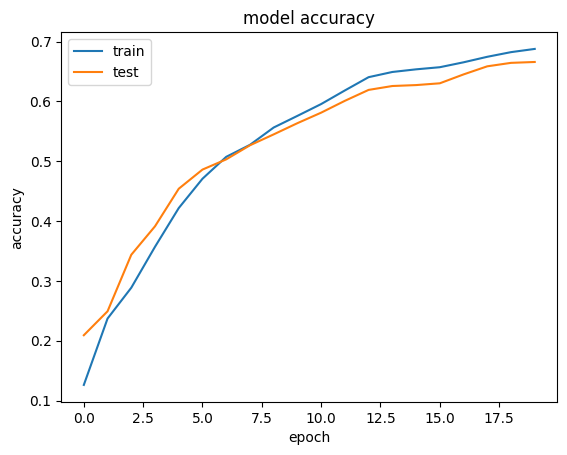

In [ ]:
plot_accuracy(histories_dict)

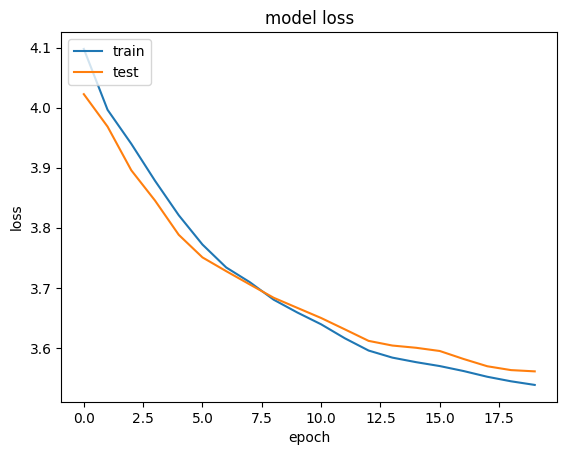

In [ ]:
plot_loss(histories_dict)

y_test, y_pred: (71280, 65) torch.Size([16, 65])


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Balanced_accuracy:0.6607549857549858


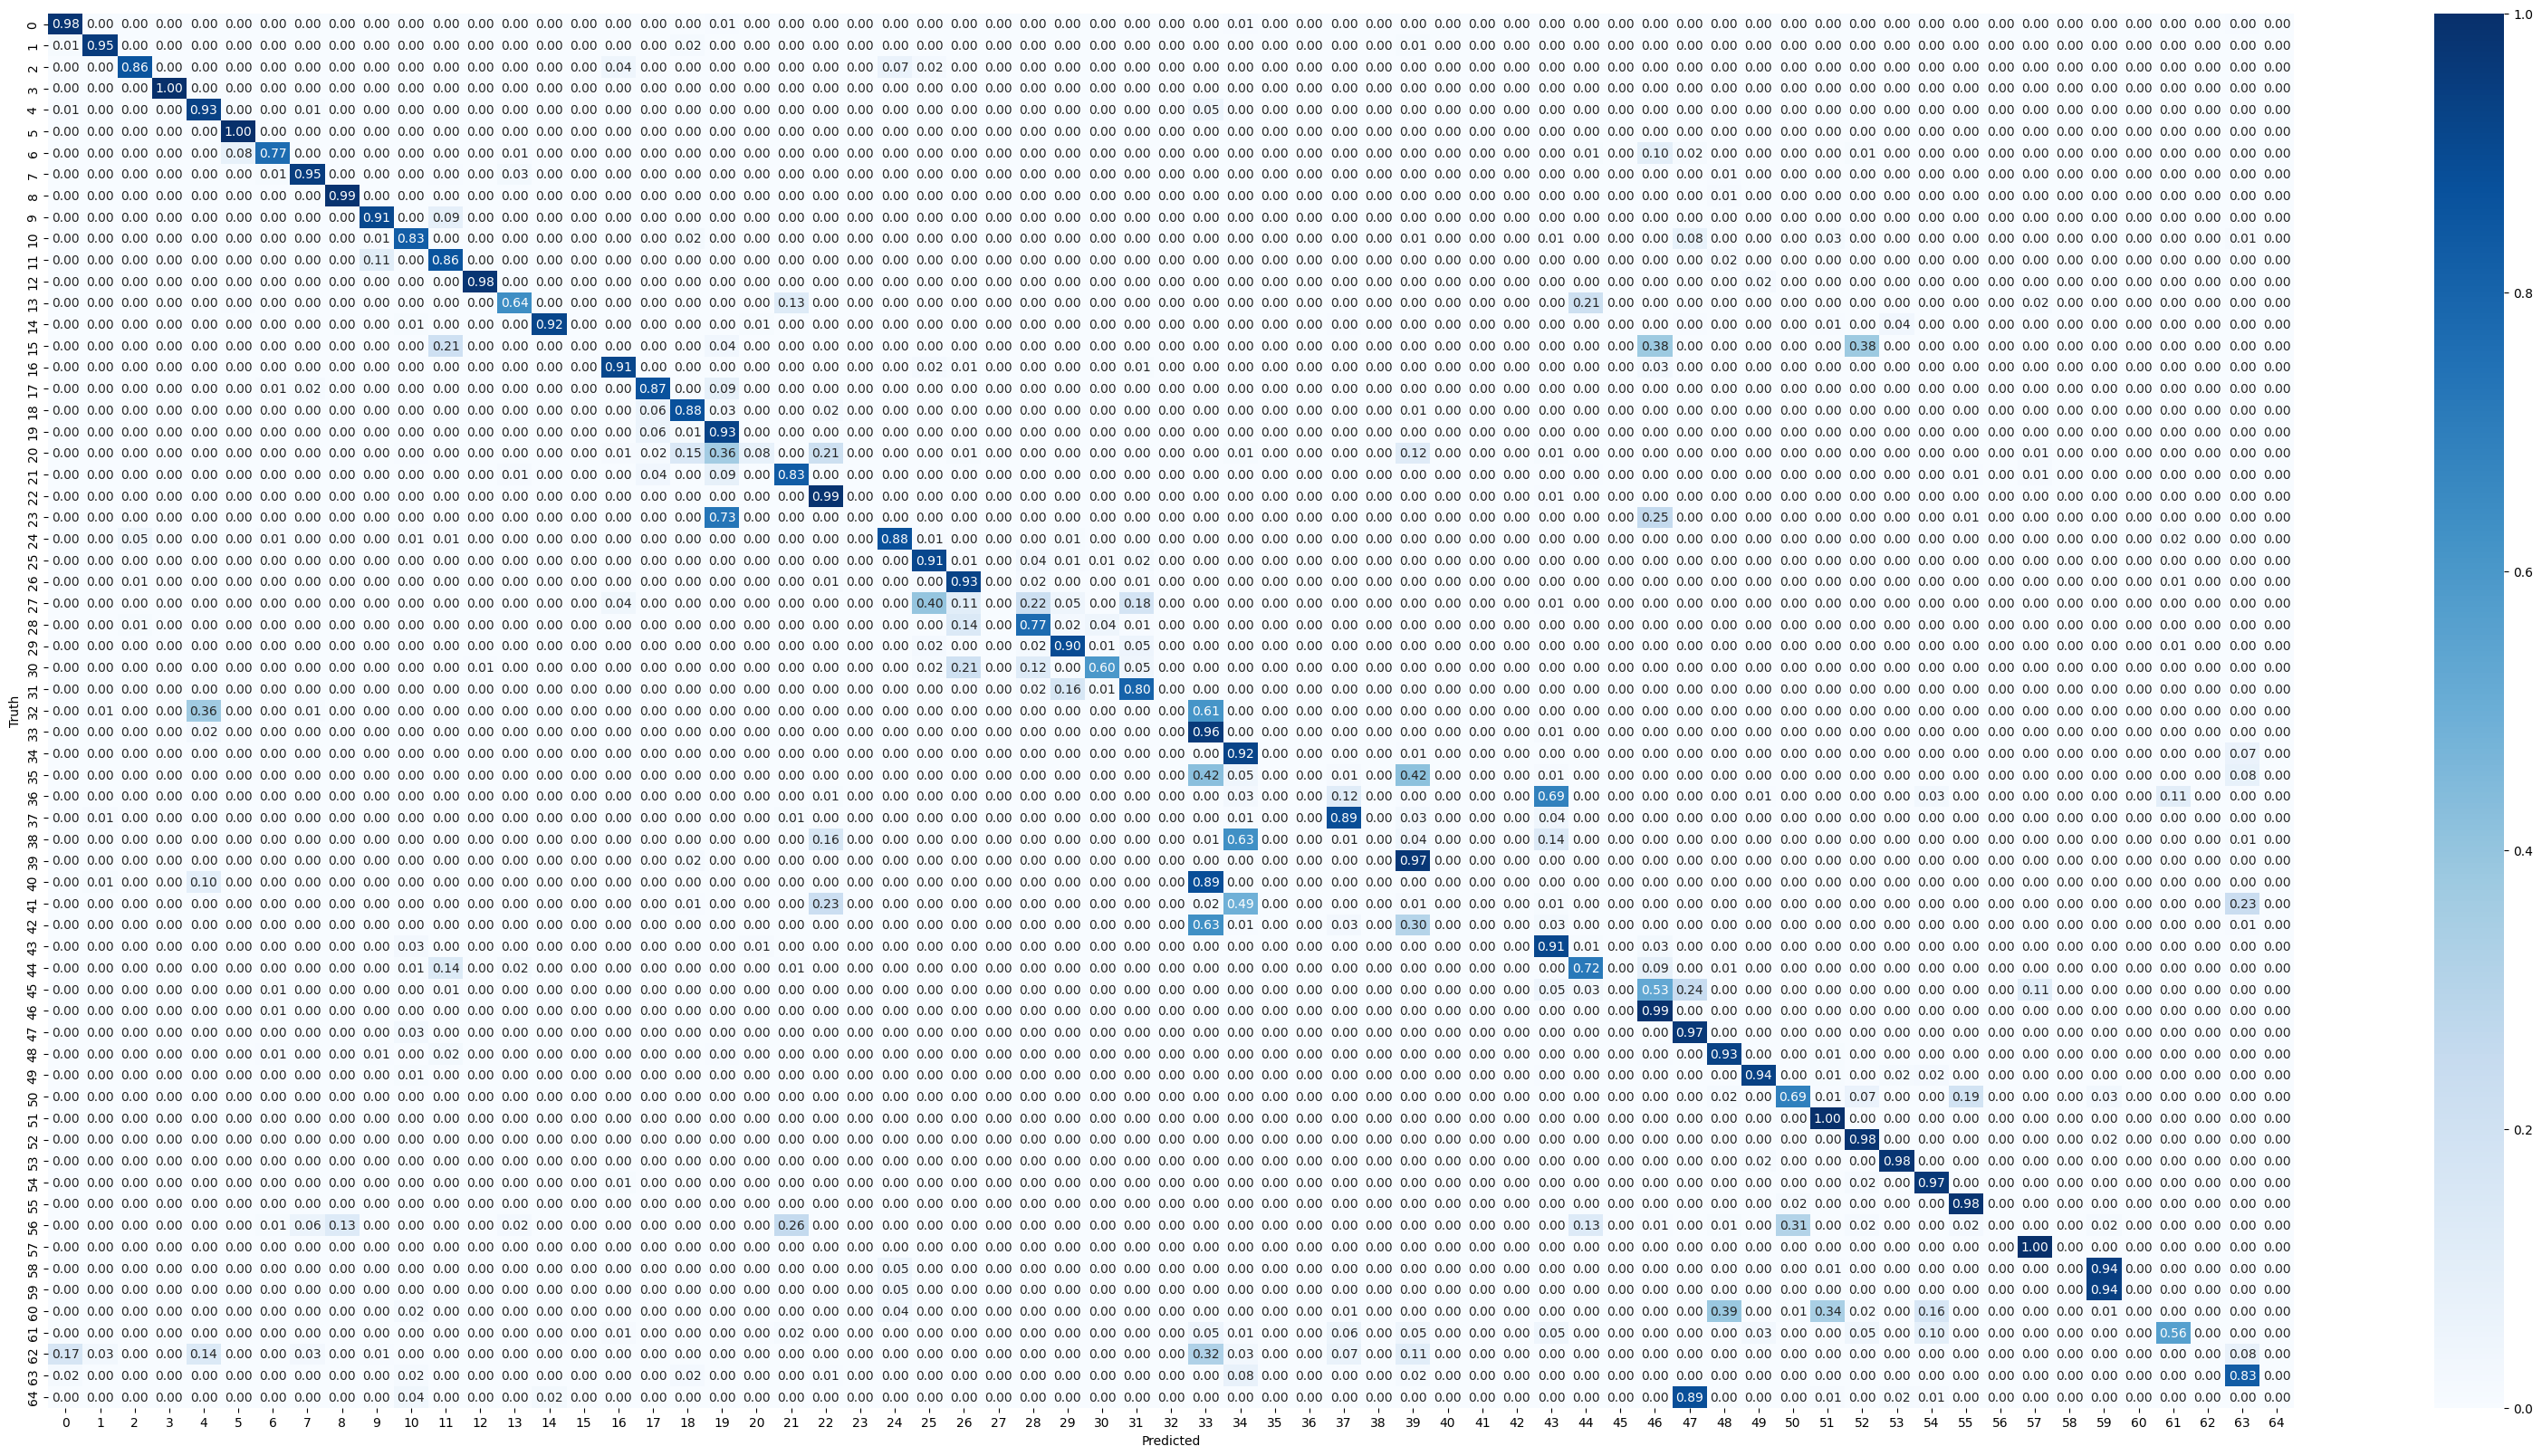

In [ ]:
y_test = np.array(h5py.File(h5_test_data_path, 'r')['labels'])
y_tested = np.argmax(y_test,axis=1)

model.eval()
y_preds = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), torch.argmax(labels, dim=1).to(device)
        y_pred = model(inputs)
        y_preds.append(y_pred)
y_preds = torch.vstack(y_preds).detach().cpu().numpy()
y_preds = np.argmax(y_preds, axis=1)
print("y_test, y_pred:", y_test.shape, y_pred.shape)

data = []
data.append(y_tested)
data.append(y_preds)
data = np.vstack(data).T
data_df = pd.DataFrame(data, columns = ['actual labels', 'predicted labels'])
report, c_matrix, norm_c_matrix, balanced_accuracy = Statistics(data_df, y_test)

In [ ]:
print(report)

              precision    recall  f1-score       support  specificity
0              0.822568  0.978704  0.893869   1080.000000     0.996752
1              0.938980  0.954630  0.946740   1080.000000     0.999046
2              0.928215  0.862037  0.893903   1080.000000     0.998974
3              0.992647  1.000000  0.996310   1080.000000     0.999886
4              0.595266  0.931481  0.726354   1080.000000     0.990256
...                 ...       ...       ...           ...          ...
63             0.621191  0.830556  0.710777   1080.000000     0.992208
64             0.000000  0.000000  0.000000   1080.000000     1.000000
accuracy       0.665895  0.665895  0.665895      0.665895     0.665895
macro avg      0.548241  0.660755  0.581019  71280.000000     0.994780
weighted avg   0.553945  0.665895  0.586774  71280.000000     0.994821

[68 rows x 5 columns]
